In [1]:
import cfgrib
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [2]:
data_path = "/Users/fquareng/AdaptationSandbox/data/6e647e250b9f05c076fff6a2a43b49da.grib"

**Note**: ERA5 GRIB files that contain multiple variables, such as t2m (2-meter temperature) and tp (total precipitation), can cause issues because cfgrib requires uniform metadata for each dataset. 

**Note**: The *shortName* is different from the *Data Variables* entry.

In [3]:
surf_data = xr.open_dataset(data_path, engine="cfgrib", filter_by_keys={"shortName": ["2t", "sp", "10u", "10v"]})
tp_data = xr.open_dataset(data_path, engine="cfgrib", filter_by_keys={"shortName": "tp"})
tp_data

Ignoring index file '/Users/fquareng/AdaptationSandbox/data/6e647e250b9f05c076fff6a2a43b49da.grib.47d85.idx' incompatible with GRIB file
Ignoring index file '/Users/fquareng/AdaptationSandbox/data/6e647e250b9f05c076fff6a2a43b49da.grib.47d85.idx' incompatible with GRIB file


<xarray.Dataset> Size: 29MB
Dimensions:     (time: 1848, step: 2, latitude: 117, longitude: 17)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 15kB 2010-12-31T18:00:00 ... 2021-12-07...
  * step        (step) timedelta64[ns] 16B 06:00:00 12:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  (time, step) datetime64[ns] 30kB ...
Data variables:
    tp          (time, step, latitude, longitude) float32 29MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-10T09:56 GRIB to CDM+CF via cfgrib-0.9.1...

# Plot

In [4]:
# Plotting function for consistent styling
def plot_variable(ax, var, title, cmap, units, vmin=None, vmax=None):
    """Plots a single variable with Cartopy."""
    var.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'label': units},
    )
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.8)
    ax.set_title(title)

In [15]:
# Select a specific time (e.g., 2011-01-01 00:00 UTC)
time_selection = "2011-01-01T06:00"
t2m = surf_data['t2m'].sel(time=time_selection)
u10 = surf_data['u10'].sel(time=time_selection)
v10 = surf_data['v10'].sel(time=time_selection)
sp = surf_data['sp'].sel(time=time_selection)
print(sp)

<xarray.DataArray 'sp' (latitude: 117, longitude: 17)> Size: 8kB
[1989 values with dtype=float32]
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B 2011-01-01T06:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             134
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1989
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sp
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:         

In [16]:
time_selection = "2011-01-01T06:00"
tp = tp_data['tp'].sel(time=time_selection, method='nearest', step="06:00:00")
print(tp)

<xarray.DataArray 'tp' (latitude: 117, longitude: 17)> Size: 8kB
[1989 values with dtype=float32]
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B 2011-01-01T06:00:00
    step        timedelta64[ns] 8B 06:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1989
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_shortName:                           tp
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:       

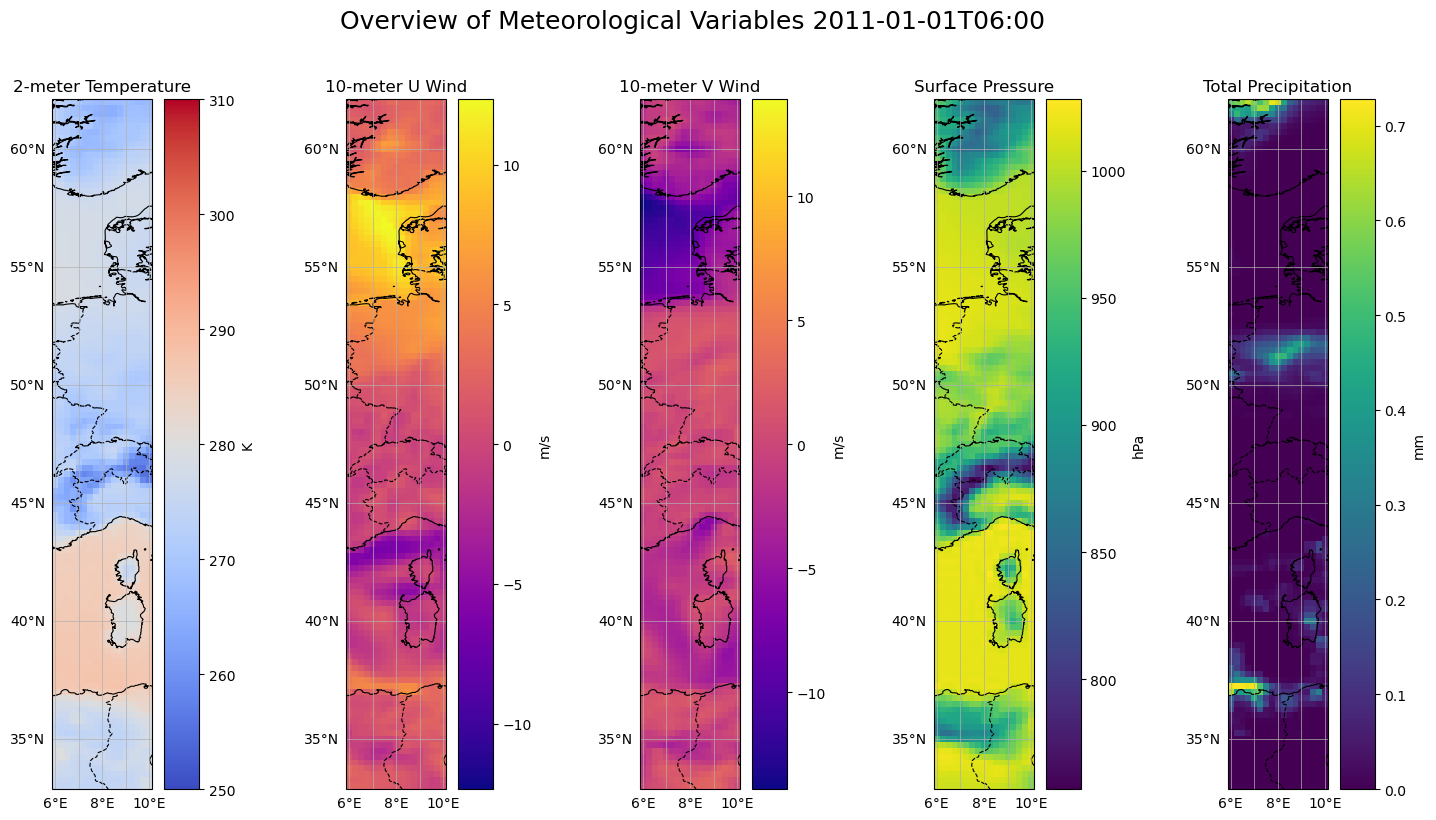

In [19]:
# Create the figure with horizontal subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})


# Plot each variable
plot_variable(axs[0], t2m, "2-meter Temperature", "coolwarm", "K", vmin=250, vmax=310)
plot_variable(axs[1], u10, "10-meter U Wind", "plasma", "m/s")
plot_variable(axs[2], v10, "10-meter V Wind", "plasma", "m/s")
plot_variable(axs[3], sp / 100, "Surface Pressure", "viridis", "hPa")  # Convert Pa to hPa
plot_variable(axs[4], tp * 1000, "Total Precipitation", "viridis", "mm")

# Add gridlines and ticks
for i in range(len(axs)):
    gl = axs[i].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=.5)
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.left_labels = True  # Enable latitude labels on the left
    gl.right_labels = False  # Disable latitude labels on the right
    gl.top_labels = False  # Disable longitude labels on the top
    gl.bottom_labels = True

fig.suptitle(f"Overview of Meteorological Variables {time_selection}", fontsize=18, y=1.02)

# Adjust layout
plt.tight_layout()


## Monthly mean distribution

In [94]:
t2m = surf_data['t2m'] 
monthly_mean_t2m = t2m.groupby('time.month').mean(dim=['time'])

In [95]:
jan = monthly_mean_t2m.groupby('month')[1]
apr = monthly_mean_t2m.groupby('month')[4]
jul = monthly_mean_t2m.groupby('month')[7]
oct = monthly_mean_t2m.groupby('month')[10]

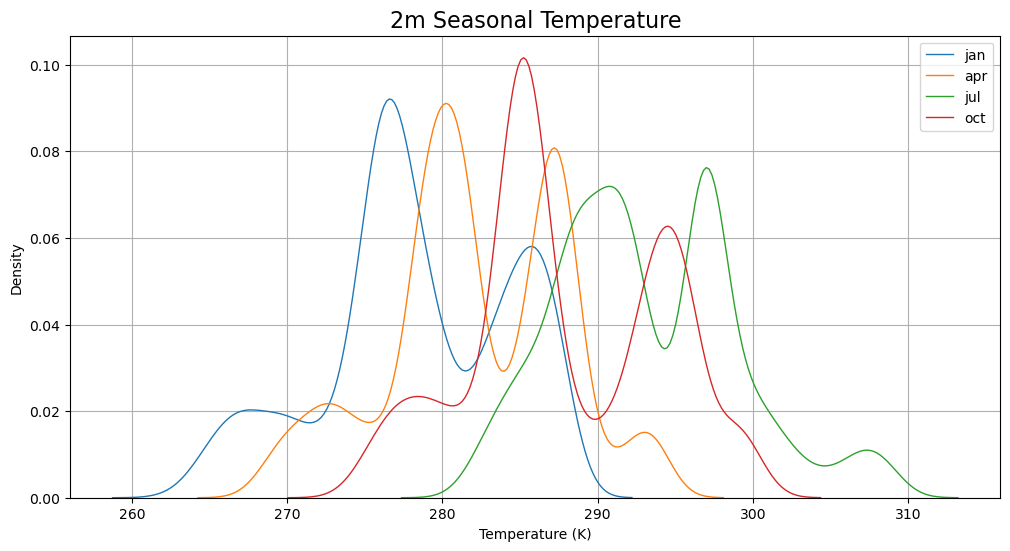

In [96]:
plt.figure(figsize=(12, 6))
plt.title("2m Seasonal Temperature", fontsize=16)
plt.xlabel("Temperature (K)")
plt.ylabel("Density")
plt.grid(True)

sns.kdeplot(jan.values.flatten(), linewidth=1, label=f"jan")
sns.kdeplot(apr.values.flatten(), linewidth=1, label=f"apr")
sns.kdeplot(jul.values.flatten(), linewidth=1, label=f"jul")
sns.kdeplot(oct.values.flatten(), linewidth=1, label=f"oct")

plt.legend()
plt.show()

In [97]:
tp = tp_data['tp'] 
monthly_mean_tp = tp.groupby('time.month').mean(dim=['time', 'step'])

In [98]:
jan = monthly_mean_tp.groupby('month')[1]
apr = monthly_mean_tp.groupby('month')[4]
jul = monthly_mean_tp.groupby('month')[7]
oct = monthly_mean_tp.groupby('month')[10]

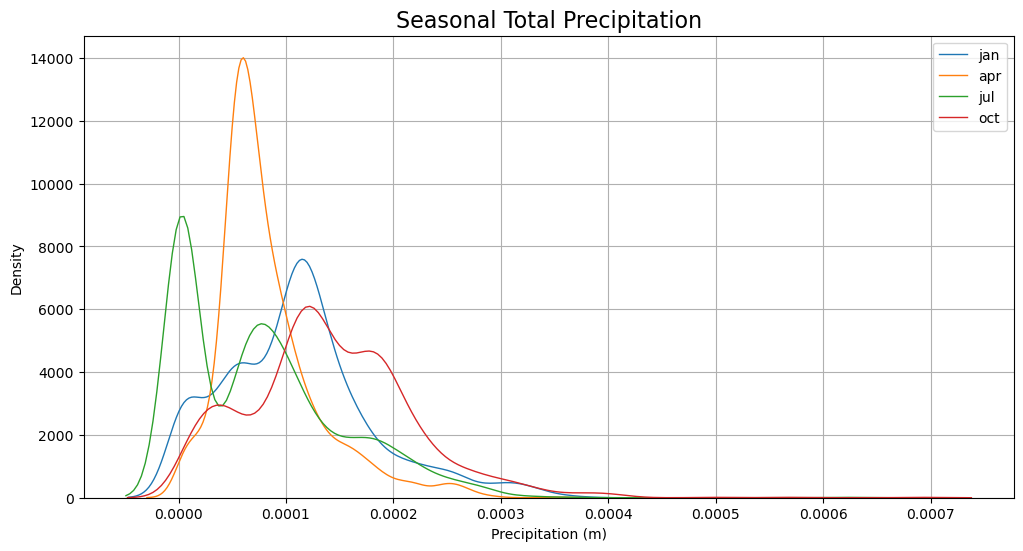

In [99]:
plt.figure(figsize=(12, 6))
plt.title("Seasonal Total Precipitation", fontsize=16)
plt.xlabel("Precipitation (m)")
plt.ylabel("Density")
plt.grid(True)

sns.kdeplot(jan.values.flatten(), linewidth=1, label=f"jan")
sns.kdeplot(apr.values.flatten(), linewidth=1, label=f"apr")
sns.kdeplot(jul.values.flatten(), linewidth=1, label=f"jul")
sns.kdeplot(oct.values.flatten(), linewidth=1, label=f"oct")

plt.legend()
plt.show()

# Regions

## South Scandinavia

In [100]:
lat_min, lat_max = 57, 62  # Switzerland
subset_tp_sca = tp_data.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
monthly_mean_tp_sca = subset_tp_sca.tp.groupby('time.month').mean(dim=['time', 'step'])
jan_sca = monthly_mean_tp_sca.groupby('month')[1]
apr_sca = monthly_mean_tp_sca.groupby('month')[4]
jul_sca = monthly_mean_tp_sca.groupby('month')[7]
oct_sca = monthly_mean_tp_sca.groupby('month')[10]

## North Germany

In [101]:
lat_min, lat_max = 50, 55  # Switzerland
subset_tp_ger = tp_data.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
monthly_mean_tp_ger = subset_tp_ger.tp.groupby('time.month').mean(dim=['time', 'step'])
jan_ger = monthly_mean_tp_ger.groupby('month')[1]
apr_ger = monthly_mean_tp_ger.groupby('month')[4]
jul_ger = monthly_mean_tp_ger.groupby('month')[7]
oct_ger = monthly_mean_tp_ger.groupby('month')[10]

## Switzerland

In [102]:
lat_min, lat_max = 45.8, 47.8  # Switzerland
subset_tp_swiss = tp_data.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
monthly_mean_tp_swiss = subset_tp_swiss.tp.groupby('time.month').mean(dim=['time', 'step'])
jan_swiss = monthly_mean_tp_swiss.groupby('month')[1]
apr_swiss = monthly_mean_tp_swiss.groupby('month')[4]
jul_swiss = monthly_mean_tp_swiss.groupby('month')[7]
oct_swiss = monthly_mean_tp_swiss.groupby('month')[10]

## North Africa

In [103]:
lat_min, lat_max = 33, 38  # Switzerland
subset_tp_na = tp_data.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
monthly_mean_tp_na = subset_tp_na.tp.groupby('time.month').mean(dim=['time', 'step'])
jan_na = monthly_mean_tp_na.groupby('month')[1]
apr_na = monthly_mean_tp_na.groupby('month')[4]
jul_na = monthly_mean_tp_na.groupby('month')[7]
oct_na = monthly_mean_tp_na.groupby('month')[10]

## Plot

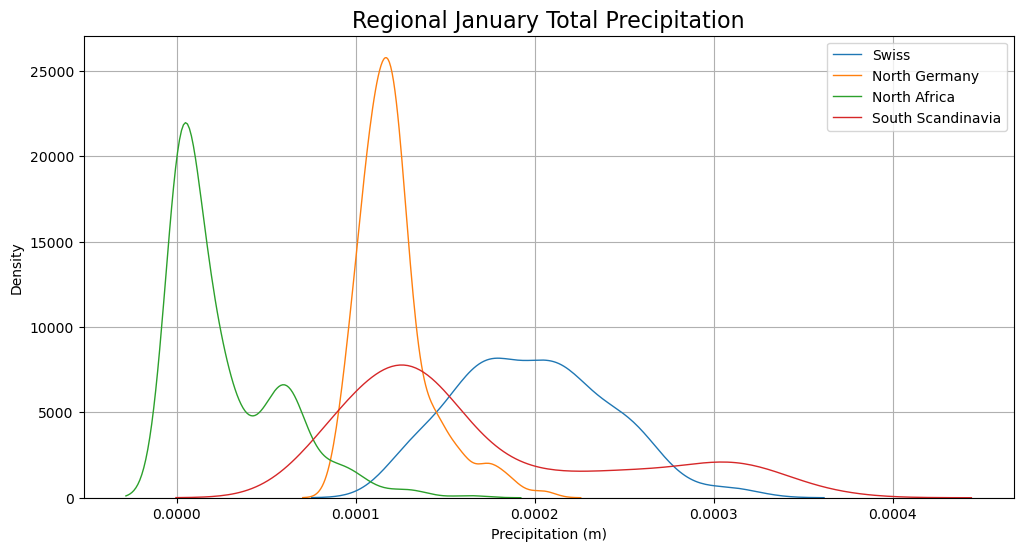

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Regional January Total Precipitation", fontsize=16)
plt.xlabel("Precipitation (m)")
plt.ylabel("Density")
plt.grid(True)

sns.kdeplot(jan_swiss.values.flatten(), linewidth=1, label=f"Swiss")
sns.kdeplot(jan_ger.values.flatten(), linewidth=1, label=f"North Germany")
sns.kdeplot(jan_na.values.flatten(), linewidth=1, label=f"North Africa")
sns.kdeplot(jan_sca.values.flatten(), linewidth=1, label=f"South Scandinavia")

plt.legend()
plt.show()